# 本田圭佑とじゅいんいちダビッドソンの識別AI

## やること
本田圭佑とじゅいんいちダビッドソンの画像をネットで収集し、
ResNet18で転移学習することで識別AIを作成する

## データ内容
以下のフォルダ構成、枚数で訓練、テスト用画像を用意した。
なお、画像群はネット上からスクレイピングで収集した後、適切でないもの（複数人写ってるもの、他の人物が写っているもの、顔がしっかりと認識できないもの）を除き、同数枚になるようにそろえた。

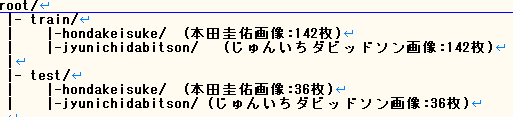

集めた画像を使ってモデル作成するためにGoogle Driveをマウントします。

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


必要なものをインポートします。

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
from torch import optim
import torch.nn as nn
import torch

訓練用、テスト用に収集した画像群にそれぞれ前処理をかけ、ラベル付きでデータセットを作成する

＜前処理内容＞
- ResNet用に256×256にリサイズする
- 画像を左右反転をしてデータ拡張する
- 正規化する

In [19]:
train_img = ImageFolder(
    "/content/drive/MyDrive/cnnsample/pics/train/",
    transform = transforms.Compose([
             transforms.Resize((256,256)),
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.ToTensor(),
             transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
       ]))

test_img = ImageFolder(
    "/content/drive/MyDrive/cnnsample/pics/test/",
    transform = transforms.Compose([
             transforms.Resize((256,256)),
             transforms.ToTensor(),
             transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
       ]))
print(len(train_img))
print(len(test_img))
print(train_img)

284
72
Dataset ImageFolder
    Number of datapoints: 284
    Root location: /content/drive/MyDrive/cnnsample/pics/train/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
           )


バッチで処理するためにDataLoderを訓練用、テスト用に作成する。

In [20]:
train_loader = DataLoader(train_img, batch_size=32, shuffle=True)
val_loader   = DataLoader(test_img, batch_size=len(test_img), shuffle=False)

訓練用画像の一部を表示してみる。

torch.Size([32, 3, 256, 256])


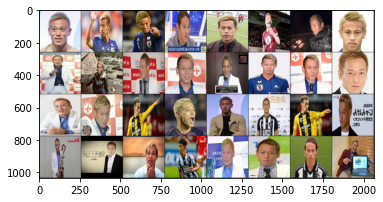

In [21]:
def imshow(img):  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 訓練データをランダムに取得
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 画像の表示
print(images.size())
imshow(torchvision.utils.make_grid(images))

In [22]:
# 転移学習用のResnet18をロード
net = models.resnet18(pretrained=True)

# すべてのパラメータを微分対象外にする
for p in net.parameters():
    p.requires_grad=False

# 全結合層、ドロップアウト層を加える
net.fc = nn.Linear(512, 200)
net.drop = nn.Dropout(0.25)
net.fc2 = nn.Linear(200, 2)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# 評価のヘルパー関数 
train_losses = [] 
test_losses = []
train_acc = [] 
val_acc = []
def eval_net(net, data_loader, device ="cpu"): 
  # DropoutやBatchNormを無効化 
  net.eval() 
  ys = [] 
  ypreds = [] 
  for x, t in data_loader: 
    # toメソッドで計算を実行するデバイスに転送する 
    x = x.to(device) 
    t = t.to(device) 

    y = net(x)
    loss_test = nn.CrossEntropyLoss()(y, t).item()
    test_losses.append(loss_test)

    # ここではfowardの計算だけなので自動部分に 
    # 必要な余計な処理はoffにする 
    with torch.no_grad(): 
      _, y_pred = net(x).max(1)
    ys.append(t) 
    ypreds.append(y_pred) 
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys) 
    ypreds = torch.cat(ypreds) 
    # 予測精度を計算 
    acc = (ys == ypreds).float().sum()/len(ys)
    return acc.item() 
# 訓練のヘルパー関数 
def train_net(net, train_loader, test_loader,
              only_fc = True,
              loss_fn = nn.CrossEntropyLoss(),
              n_iter = 10, device ="cpu"): 
    
    # 転移学習の際は最後の1層のみoptimizerに渡す
    if only_fc:
      optimizer = optim.Adam(net.fc.parameters())
    else:
      optimizer = optim.Adam(net.parameters())
    for epoch in range(n_iter): 
      running_loss = 0.0 
      # ネットワークを訓練モードにする 
      net.train() 
      n = 0 
      n_acc = 0 

      for i, (xx, tt) in enumerate(train_loader): 
        xx = xx.to(device) 
        tt = tt.to(device) 
        h = net(xx) 
        loss = loss_fn(h, tt) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item() 
        n += len(xx) 
        _, y_pred = h. max(1) 
        n_acc += (tt == y_pred). float(). sum().item() 

      train_losses.append(running_loss / i)
      
      # 訓練データの予測精度 
      train_acc.append(n_acc / n) 
      # 検証データの予測精度 
      val_acc.append(eval_net(net, test_loader, device)) 
      # このepochでの結果を表示 

      print("Epoch:", epoch, "Train_Loss:", train_losses[- 1], "Train_Acc:", train_acc[-1], "Val_Acc:", val_acc[-1], flush = True)





In [24]:
net.to("cuda:0")
train_net(net, train_loader, val_loader, only_fc = True, n_iter = 20, device ="cuda:0")

Epoch: 0 Train_Loss: 3.1435205787420273 Train_Acc: 0.31690140845070425 Val_Acc: 0.5277777910232544
Epoch: 1 Train_Loss: 0.8608112335205078 Train_Acc: 0.49295774647887325 Val_Acc: 0.569444477558136
Epoch: 2 Train_Loss: 0.7292762845754623 Train_Acc: 0.647887323943662 Val_Acc: 0.75
Epoch: 3 Train_Loss: 0.6519424840807915 Train_Acc: 0.7147887323943662 Val_Acc: 0.7777777910232544
Epoch: 4 Train_Loss: 0.5999457649886608 Train_Acc: 0.7535211267605634 Val_Acc: 0.8055555820465088
Epoch: 5 Train_Loss: 0.5374265983700752 Train_Acc: 0.8169014084507042 Val_Acc: 0.8055555820465088
Epoch: 6 Train_Loss: 0.4965130686759949 Train_Acc: 0.8133802816901409 Val_Acc: 0.7916666865348816
Epoch: 7 Train_Loss: 0.45675187930464745 Train_Acc: 0.8380281690140845 Val_Acc: 0.7916666865348816
Epoch: 8 Train_Loss: 0.4417932331562042 Train_Acc: 0.8450704225352113 Val_Acc: 0.7777777910232544
Epoch: 9 Train_Loss: 0.4049080014228821 Train_Acc: 0.8838028169014085 Val_Acc: 0.7916666865348816
Epoch: 10 Train_Loss: 0.396098162

訓練データ、テストデータで誤差の推移、正解率をグラフ表示します。
ほぼほぼ最初の時点で過学習を起こしていることがわかります。

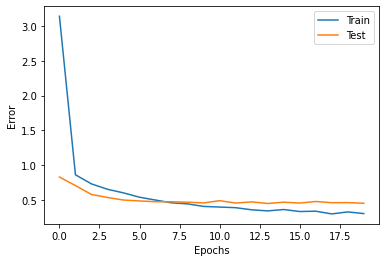

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(len(test_losses)), test_losses, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

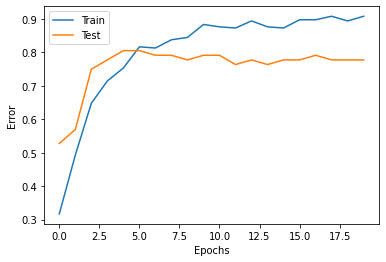

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_acc)), train_acc, label="Train")
plt.plot(range(len(val_acc)), val_acc, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

テストデータで実際に予測をしてみて、間違えたものだけ表示する。
画像を確認してみると、顔が小さかったり、最近の本田圭佑は推測が難しいことがわかる

1
1
1
1
0
1


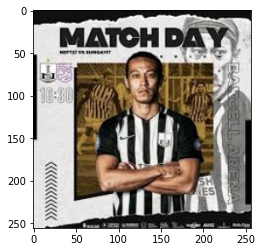

正解: hondakeisuke 予測結果: jyunichidabitson
71.43189907073975
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


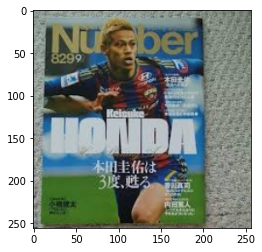

正解: hondakeisuke 予測結果: jyunichidabitson
93.01207065582275
0


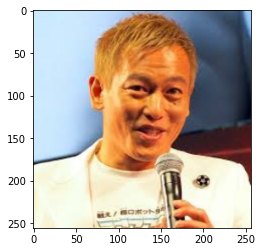

正解: jyunichidabitson 予測結果: hondakeisuke
88.82508277893066
0


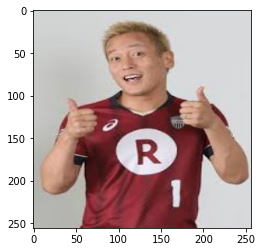

正解: jyunichidabitson 予測結果: hondakeisuke
65.70084691047668
1


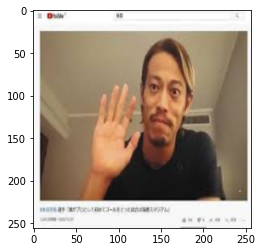

正解: hondakeisuke 予測結果: jyunichidabitson
89.11988735198975
1
1


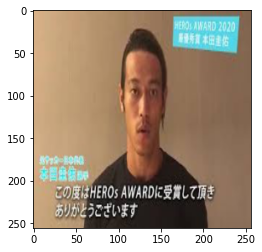

正解: hondakeisuke 予測結果: jyunichidabitson
66.98371767997742
1
0
0
0
0
0
1


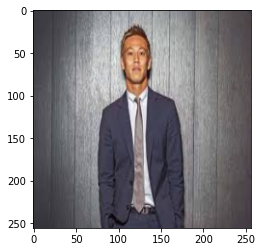

正解: hondakeisuke 予測結果: jyunichidabitson
85.23014187812805
0
1
0
0


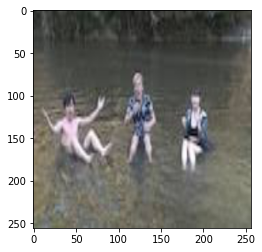

正解: jyunichidabitson 予測結果: hondakeisuke
65.11307954788208
1
0
1
0
1
0
1
1
0
1
0
0
1
1
0
0
0


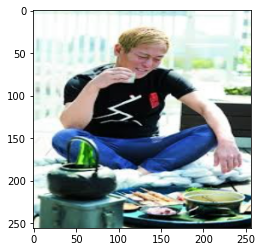

正解: jyunichidabitson 予測結果: hondakeisuke
52.56801247596741
0
1


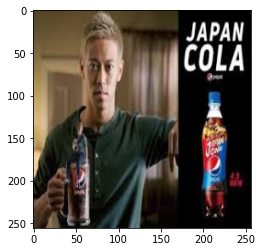

正解: hondakeisuke 予測結果: jyunichidabitson
60.93480587005615
1
1
1


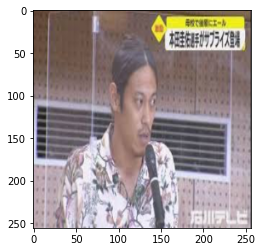

正解: hondakeisuke 予測結果: jyunichidabitson
59.741681814193726
1
0
0


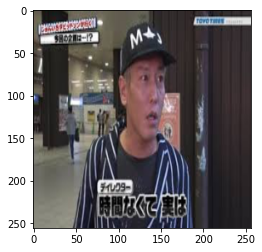

正解: jyunichidabitson 予測結果: hondakeisuke
77.48078107833862
1
0


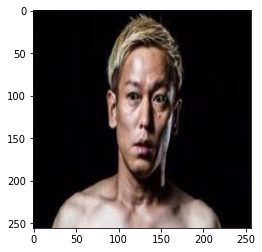

正解: jyunichidabitson 予測結果: hondakeisuke
83.38984251022339
0
1


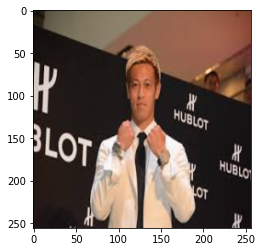

正解: hondakeisuke 予測結果: jyunichidabitson
57.361793518066406
0
0
1


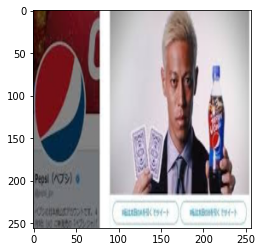

正解: hondakeisuke 予測結果: jyunichidabitson
89.16639685630798
0
1
0
1
1
1
1
0


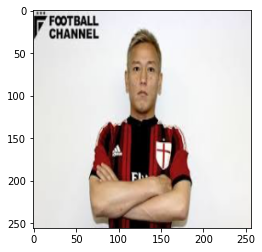

正解: jyunichidabitson 予測結果: hondakeisuke
73.38960766792297
1
0
1
0
1
1
1
0
0


In [27]:
from torch.utils.data import DataLoader
from torch.nn import functional as F

test_loder = DataLoader(test_img, batch_size=1, shuffle=True)
dataiter = iter(test_loder)
images, labels = dataiter.next()


for i, (x, t) in enumerate(test_loder):
  net.eval()  # 評価モード
  xx, t = x.cuda(), t.cuda()  # GPU対応
  y = net(xx)
  print(y.argmax().item())
  if (train_img.classes[t] != train_img.classes[y.argmax().item()]):
    imshow(torchvision.utils.make_grid(x))
    print("正解:", train_img.classes[t],
          "予測結果:", train_img.classes[y.argmax().item()])
    print(F.softmax(y).max().item()*100)

# 課題
初期段階で過学習を起こしている

# 対策
- 画像群を顔だけ切り出してみる
- データ拡張を上手くやる
- 外れ値（枚数の少ない最近の本田圭佑の画像）を除く


In [28]:
import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["fc.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "honda_cnn.pth")  

conv1.weight :  torch.Size([64, 3, 7, 7])
bn1.weight :  torch.Size([64])
bn1.bias :  torch.Size([64])
bn1.running_mean :  torch.Size([64])
bn1.running_var :  torch.Size([64])
bn1.num_batches_tracked :  torch.Size([])
layer1.0.conv1.weight :  torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight :  torch.Size([64])
layer1.0.bn1.bias :  torch.Size([64])
layer1.0.bn1.running_mean :  torch.Size([64])
layer1.0.bn1.running_var :  torch.Size([64])
layer1.0.bn1.num_batches_tracked :  torch.Size([])
layer1.0.conv2.weight :  torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight :  torch.Size([64])
layer1.0.bn2.bias :  torch.Size([64])
layer1.0.bn2.running_mean :  torch.Size([64])
layer1.0.bn2.running_var :  torch.Size([64])
layer1.0.bn2.num_batches_tracked :  torch.Size([])
layer1.1.conv1.weight :  torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight :  torch.Size([64])
layer1.1.bn1.bias :  torch.Size([64])
layer1.1.bn1.running_mean :  torch.Size([64])
layer1.1.bn1.running_var :  torch.Size([64])
layer1.1.bn1.num_b

In [29]:
# 転移学習用のResnet18をロード
net = models.resnet18(pretrained=True)

# すべてのパラメータを微分対象外にする
for p in net.parameters():
    p.requires_grad=False

# 全結合層、ドロップアウト層を加える
net.fc = nn.Linear(512, 200)
net.drop = nn.Dropout(0.25)
net.fc2 = nn.Linear(200, 2)

net.load_state_dict(torch.load("honda_cnn.pth", map_location=torch.device("cpu")))  #CPU対応
net.eval()  # 評価モード

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])

conv1.weight :  torch.Size([64, 3, 7, 7])
bn1.weight :  torch.Size([64])
bn1.bias :  torch.Size([64])
bn1.running_mean :  torch.Size([64])
bn1.running_var :  torch.Size([64])
bn1.num_batches_tracked :  torch.Size([])
layer1.0.conv1.weight :  torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight :  torch.Size([64])
layer1.0.bn1.bias :  torch.Size([64])
layer1.0.bn1.running_mean :  torch.Size([64])
layer1.0.bn1.running_var :  torch.Size([64])
layer1.0.bn1.num_batches_tracked :  torch.Size([])
layer1.0.conv2.weight :  torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight :  torch.Size([64])
layer1.0.bn2.bias :  torch.Size([64])
layer1.0.bn2.running_mean :  torch.Size([64])
layer1.0.bn2.running_var :  torch.Size([64])
layer1.0.bn2.num_batches_tracked :  torch.Size([])
layer1.1.conv1.weight :  torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight :  torch.Size([64])
layer1.1.bn1.bias :  torch.Size([64])
layer1.1.bn1.running_mean :  torch.Size([64])
layer1.1.bn1.running_var :  torch.Size([64])
layer1.1.bn1.num_b

In [30]:
print(train_img.classes)

['hondakeisuke', 'jyunichidabitson']


In [31]:
print('PyTorch', torch.__version__)

PyTorch 1.9.0+cu102


In [ ]:
print('', torch.__version__)